# Process
In this notebook, I will do a first analysis of gender distribution on the data so that I can use it later on.

# A. Import Libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import random as rd
import pandas as pd
import numpy as np
from analyze_data import read_popularity, users_and_items, user_distribution,item_distribution, calculate_popularity, calculate_group_characteristics, calculate_gini_coefficient
from plots import plot_data_distribution, plot_popularity_distribution, plot_profile_size_vs_popularity, plot_group_characteristics, plot_Lorenz
import tqdm 
from split_users import sort_user_dist, split, split_differently
import time
import pickle as pkl
from sklearn.model_selection import train_test_split
pd.set_option("display.precision", 5)

## B. Set hyperparameters
There are certain hyperparameters that need to be tuned before the run. 

In [16]:
item_threshold = 5 # remove users with less than item_threshold items
user_threshold = 5 # remove items with less than user_threshold users
top_threshold = 200 # remove users who have rated more than top_threshold items
recommendation_type = "books" # books, music or movies
item_col = "ISBN" # the item column
my_seed = 0 # random_seed
top_fraction_items = 0.2 # the limit for an item to be considered popular
top_fraction_users = 0.2# the limit for a user to be considered High Mainstriminess
split_by = "pop_fraq" # sort users by fraction of popular items (pop_fraq) or by average popularity in profile (pop_item_fraq)

These additions will be useful so we can save the different files (plots and processed data) with clarity on the hyperparameters.

In [17]:
addition_1 = "_u"+str(item_threshold)+"_i"+str(user_threshold)+"_t"+str(top_threshold)
addition_2 = addition_1 + "_tfi"+str(int(100*top_fraction_items))
addition_3 = addition_2 + "_tfu"+str(int(100*top_fraction_users))
addition_4 = addition_3 + ("_sbpf" if (split_by=="pop_fraq") else "_sbpif")

In [18]:
rd.seed(my_seed) #seed for random functions
np.random.seed(my_seed) #seed for all numpy fuctions

# C. Read files

In [19]:
properties_file_location = "data/files_with_properties/" # here are stored the data files that include author properties
item_file = properties_file_location + "fairbook_books.csv" # the items file
items_with_properties = pd.read_csv(item_file, index_col=0, header=0, low_memory=False).fillna("")

ratings_file = properties_file_location + "fairbook_ratings.csv" # the ratings file
ratings_with_properties = pd.read_csv(ratings_file, index_col=0, header=0, low_memory=False).fillna("")

In [20]:
ratings_with_properties.head()

,User-ID,ISBN,Book-Rating,QID,viaf_id,sexuality,country,language,religion,gender,ethnicity,birthyear,deathyear,title,author,year,publisher
0,276847,3426029553,8,,,,,,,,,,,,,,
1,276847,3551551677,10,Q34660,116796842,,United Kingdom,English,Anglicanism,female,English people,1965.0,,Harry Potter und der Stein der Weisen,Joanne K. Rowling,1999.0,Carlsen Verlag GmbH
2,276847,3551551685,10,Q34660,116796842,,United Kingdom,English,Anglicanism,female,English people,1965.0,,Harry Potter und die Kammer des Schreckens,Joanne K. Rowling,2000.0,Carlsen Verlag GmbH
3,276847,3551551693,10,Q34660,116796842,,United Kingdom,English,Anglicanism,female,English people,1965.0,,Harry Potter und der Gefangene von Azkaban,J. K. Rowling,1999.0,Carlsen Verlag GmbH
4,276847,3551551936,10,Q34660,116796842,,United Kingdom,English,Anglicanism,female,English people,1965.0,,Harry Potter Und Der Feuerkelch,Joanne K. Rowling,1999.0,Carlsen Verlag GmbH


## D. Preprocess data
1. Convert book IDs into numbers (needed for Cornac).

In [21]:
mapping_dict = {} # Create a dictionary that maps each ISBN to an integer.
i=0
for ISBN in ratings_with_properties.ISBN.unique():
    mapping_dict[ISBN] = i
    i+=1

In [22]:
items_with_properties.ISBN = items_with_properties.ISBN.map(lambda x: mapping_dict.get(x,x)) # Map in the books file
ratings_with_properties.ISBN = ratings_with_properties.ISBN.map(lambda x: mapping_dict.get(x,x)) # Map in the books file

In [23]:
ratings_with_properties.head(2)

,User-ID,ISBN,Book-Rating,QID,viaf_id,sexuality,country,language,religion,gender,ethnicity,birthyear,deathyear,title,author,year,publisher
0,276847,0,8,,,,,,,,,,,,,,
1,276847,1,10,Q34660,116796842,,United Kingdom,English,Anglicanism,female,English people,1965.0,,Harry Potter und der Stein der Weisen,Joanne K. Rowling,1999.0,Carlsen Verlag GmbH


## E. Gender analysis

In [24]:
df = ratings_with_properties.copy()
df["gender"] = df["gender"].apply(lambda x: "unknown" if x=="" else x)
df["gender"][(df.gender!="male") & (df.gender!="female") & (df.gender!="unknown")] = "other"

/var/folders/kd/b_bt00dj1yb3ghtydwhly2gh0000gn/T/ipykernel_28664/1010661726.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["gender"][(df.gender!="male") & (df.gender!="female") & (df.gender!="unknown")] = "other"


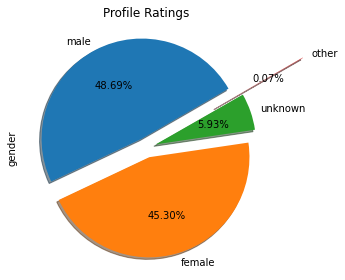

In [25]:
fig, ax = plt.subplots()
df.gender.value_counts().plot(kind="pie",autopct='%.2f%%',explode=(0.1, 0.1, 0.1,0.8), shadow=True
                                      , startangle=30)
ax.tick_params(labelrotation=0)
ax.title.set_text("Profile Ratings")
fig.tight_layout()
#fig.suptitle("Gender Distribution")

# F. Define and calculate gender odds

In [26]:
users_and_items(ratings_with_properties, "User-ID", item_col) # print properties of the ratings set
user_dist, num_users = user_distribution(ratings_with_properties, "User-ID", item_col, prnt = True) # create dataset for all users 
item_dist, num_items = item_distribution(ratings_with_properties, "User-ID", item_col, prnt = True) # create dataset for all items

No. user events: 88562
No. items: 6921
No. users: 6358


Mean ISBNs per user: 13.9
Min ISBNs per user: 5
Max ISBNs per user: 153


Mean users per ISBN: 12.8
Min users per ISBN: 5
Max users per ISBN: 350




In [28]:
user_dist

258534    153
76151     129
21014     129
273113    114
210485    112
         ... 
154269      5
154021      5
152617      5
152605      5
137397      5
Name: User-ID, Length: 6358, dtype: int64

In [ ]:
num_top = int(top_fraction_items * num_items) # choose the top_fraction_items most female oriented items

